In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_mobilenet"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  
model = MobileNet(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[4].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[7].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[12].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[17].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.4603 - acc: 0.7784 - val_loss: 0.2535 - val_acc: 0.9105
Epoch 2/1000
 - 1s - loss: 0.2391 - acc: 0.9096 - val_loss: 0.1601 - val_acc: 0.9537
Epoch 3/1000
 - 1s - loss: 0.1642 - acc: 0.9438 - val_loss: 0.1188 - val_acc: 0.9698
Epoch 4/1000
 - 1s - loss: 0.1182 - acc: 0.9617 - val_loss: 0.0925 - val_acc: 0.9754
Epoch 5/1000
 - 1s - loss: 0.0911 - acc: 0.9702 - val_loss: 0.0799 - val_acc: 0.9775
Epoch 6/1000
 - 1s - loss: 0.0710 - acc: 0.9794 - val_loss: 0.0629 - val_acc: 0.9796
Epoch 7/1000
 - 1s - loss: 0.0553 - acc: 0.9842 - val_loss: 0.0517 - val_acc: 0.9838
Epoch 8/1000
 - 1s - loss: 0.0430 - acc: 0.9890 - val_loss: 0.0433 - val_acc: 0.9846
Epoch 9/1000
 - 1s - loss: 0.0342 - acc: 0.9918 - val_loss: 0.0390 - val_acc: 0.9870
Epoch 10/1000
 - 1s - loss: 0.0291 - acc: 0.9934 - val_loss: 0.0337 - val_acc: 0.9888
Epoch 11/1000
 - 1s - loss: 0.0238 - acc: 0.9946 - val_loss: 0.0348 - val_acc: 0.9874
Epoch 12/1000
 

Epoch 94/1000
 - 1s - loss: 8.4888e-05 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9982
Epoch 95/1000
 - 1s - loss: 1.9529e-05 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9972
Epoch 96/1000
 - 1s - loss: 2.7169e-06 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 0.9965
Epoch 97/1000
 - 1s - loss: 4.7579e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9979
Epoch 98/1000
 - 1s - loss: 3.3452e-06 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 0.9975
Epoch 99/1000
 - 1s - loss: 1.3686e-05 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9982
Epoch 100/1000
 - 1s - loss: 3.5092e-06 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9972
Epoch 101/1000
 - 1s - loss: 1.1996e-05 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9972
Epoch 102/1000
 - 1s - loss: 1.6606e-05 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9972
Epoch 103/1000
 - 1s - loss: 9.2610e-06 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9972
Epoch 104/1000
 - 1s - loss: 4.8627e-06 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9979
Epoch

 - 1s - loss: 4.0010e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 185/1000
 - 1s - loss: 1.0444e-06 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9979
Epoch 186/1000
 - 1s - loss: 1.8514e-06 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9982
Epoch 187/1000
 - 1s - loss: 2.1863e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 188/1000
 - 1s - loss: 1.4083e-06 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9982
Epoch 189/1000
 - 1s - loss: 3.3165e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9979
Epoch 190/1000
 - 1s - loss: 3.3809e-07 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9982
Epoch 191/1000
 - 1s - loss: 1.8337e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 192/1000
 - 1s - loss: 8.4309e-06 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9982
Epoch 193/1000
 - 1s - loss: 2.4584e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 194/1000
 - 1s - loss: 4.5740e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9982
Epoch 195/1000

Epoch 275/1000
 - 1s - loss: 3.5850e-07 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 0.9982
Epoch 276/1000
 - 1s - loss: 2.5873e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 277/1000
 - 1s - loss: 1.4407e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 278/1000
 - 1s - loss: 1.5006e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9979
Epoch 279/1000
 - 1s - loss: 1.2976e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 280/1000
 - 1s - loss: 3.6216e-04 - acc: 0.9999 - val_loss: 0.0082 - val_acc: 0.9982
Epoch 281/1000
 - 1s - loss: 1.7814e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 282/1000
 - 1s - loss: 1.8364e-07 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 0.9979
Epoch 283/1000
 - 1s - loss: 1.6177e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 284/1000
 - 1s - loss: 1.3971e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 285/1000
 - 1s - loss: 2.9711e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9979

 - 1s - loss: 1.3007e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 366/1000
 - 1s - loss: 1.3147e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9979
Epoch 367/1000
 - 1s - loss: 1.2364e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 368/1000
 - 1s - loss: 1.5117e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 369/1000
 - 1s - loss: 1.3872e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 370/1000
 - 1s - loss: 1.3238e-07 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9982
Epoch 371/1000
 - 1s - loss: 1.4905e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 372/1000
 - 1s - loss: 1.3003e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 373/1000
 - 1s - loss: 1.4264e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982
Epoch 374/1000
 - 1s - loss: 1.3502e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9982
Epoch 375/1000
 - 1s - loss: 1.3475e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 376/1000

Epoch 456/1000
 - 1s - loss: 1.2513e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9982
Epoch 457/1000
 - 1s - loss: 1.3352e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9982
Epoch 458/1000
 - 1s - loss: 1.2114e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9982
Epoch 459/1000
 - 1s - loss: 1.4362e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 460/1000
 - 1s - loss: 2.2872e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 461/1000
 - 1s - loss: 1.2212e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9979
Epoch 462/1000
 - 1s - loss: 1.2585e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9979
Epoch 463/1000
 - 1s - loss: 1.2874e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982
Epoch 464/1000
 - 1s - loss: 1.3132e-07 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9982
Epoch 465/1000
 - 1s - loss: 1.2324e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 466/1000
 - 1s - loss: 1.3294e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982

 - 1s - loss: 1.2315e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 547/1000
 - 1s - loss: 1.3655e-07 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 548/1000
 - 1s - loss: 1.2806e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982
Epoch 549/1000
 - 1s - loss: 1.2126e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9986
Epoch 550/1000
 - 1s - loss: 1.3935e-07 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 551/1000
 - 1s - loss: 3.2976e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9979
Epoch 552/1000
 - 1s - loss: 1.2586e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 553/1000
 - 1s - loss: 1.4578e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 554/1000
 - 1s - loss: 1.2471e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9979
Epoch 555/1000
 - 1s - loss: 1.2106e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9979
Epoch 556/1000
 - 1s - loss: 1.2916e-07 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9975
Epoch 557/1000

Epoch 637/1000
 - 1s - loss: 1.4718e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9982
Epoch 638/1000
 - 1s - loss: 1.3020e-07 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 0.9979
Epoch 639/1000
 - 1s - loss: 1.2656e-07 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 0.9979
Epoch 640/1000
 - 1s - loss: 1.2028e-07 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 0.9979
Epoch 641/1000
 - 1s - loss: 1.2206e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 642/1000
 - 1s - loss: 1.2029e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9979
Epoch 643/1000
 - 1s - loss: 1.2061e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 644/1000
 - 1s - loss: 1.2111e-07 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 0.9979
Epoch 645/1000
 - 1s - loss: 1.2008e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9979
Epoch 646/1000
 - 1s - loss: 1.1970e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9979
Epoch 647/1000
 - 1s - loss: 1.2132e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9982

 - 1s - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9979
Epoch 728/1000
 - 1s - loss: 1.2016e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9979
Epoch 729/1000
 - 1s - loss: 1.2798e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 730/1000
 - 1s - loss: 1.1998e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 731/1000
 - 1s - loss: 1.2074e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 732/1000
 - 1s - loss: 1.2150e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 733/1000
 - 1s - loss: 1.3364e-07 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9982
Epoch 734/1000
 - 1s - loss: 1.1963e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9979
Epoch 735/1000
 - 1s - loss: 1.2515e-07 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 0.9982
Epoch 736/1000
 - 1s - loss: 1.2405e-07 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 0.9979
Epoch 737/1000
 - 1s - loss: 1.2049e-07 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9979
Epoch 738/1000

Epoch 818/1000
 - 1s - loss: 1.2330e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 819/1000
 - 1s - loss: 1.2206e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9982
Epoch 820/1000
 - 1s - loss: 1.2968e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9982
Epoch 821/1000
 - 1s - loss: 1.2069e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9986
Epoch 822/1000
 - 1s - loss: 1.2325e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9986
Epoch 823/1000
 - 1s - loss: 1.2259e-07 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9986
Epoch 824/1000
 - 1s - loss: 1.2393e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9979
Epoch 825/1000
 - 1s - loss: 1.2084e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 826/1000
 - 1s - loss: 1.2081e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9979
Epoch 827/1000
 - 1s - loss: 1.2088e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9979
Epoch 828/1000
 - 1s - loss: 1.2127e-07 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9982

 - 1s - loss: 1.2019e-07 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9979
Epoch 909/1000
 - 1s - loss: 1.2284e-07 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9982
Epoch 910/1000
 - 1s - loss: 2.5821e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 911/1000
 - 1s - loss: 1.2046e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9986
Epoch 912/1000
 - 1s - loss: 1.2076e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 913/1000
 - 1s - loss: 1.2150e-07 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 0.9979
Epoch 914/1000
 - 1s - loss: 1.2097e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9982
Epoch 915/1000
 - 1s - loss: 1.2059e-07 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9982
Epoch 916/1000
 - 1s - loss: 1.2099e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 917/1000
 - 1s - loss: 1.2086e-07 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9982
Epoch 918/1000
 - 1s - loss: 1.2150e-07 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9979
Epoch 919/1000

Epoch 999/1000
 - 1s - loss: 1.2058e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 1000/1000
 - 1s - loss: 1.2120e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7887323943661971


Confusion Matrix
[[31  5]
 [10 25]]


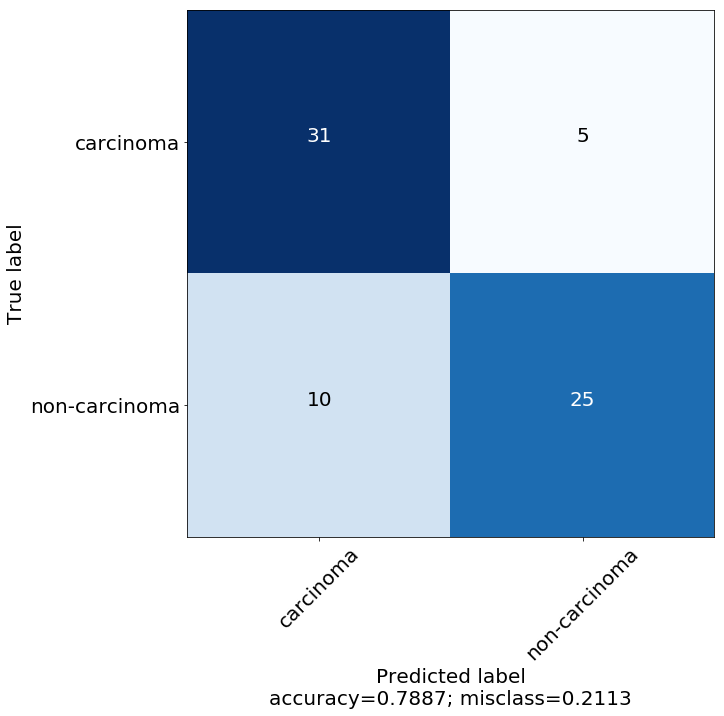

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[31  5]
 [10 25]]
               precision    recall  f1-score   support

    carcinoma       0.76      0.86      0.81        36
non-carcinoma       0.83      0.71      0.77        35

    micro avg       0.79      0.79      0.79        71
    macro avg       0.79      0.79      0.79        71
 weighted avg       0.79      0.79      0.79        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  75.60975609756098
Specificity :  83.33333333333334


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.7947154471544715


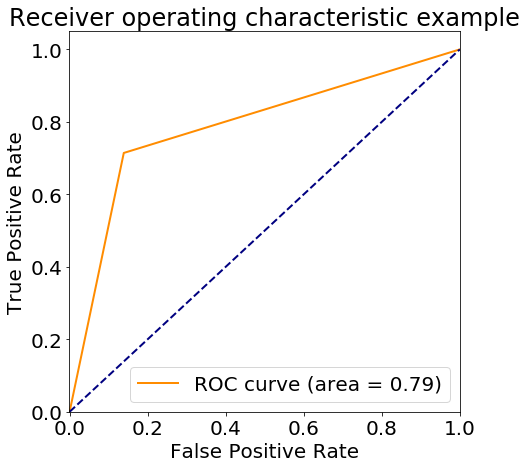

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 84us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

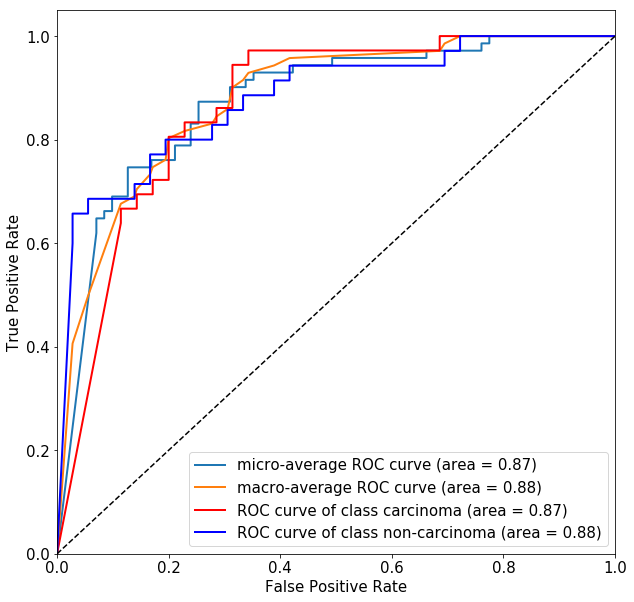

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.7887323943661971
Precision: 0.8333333333333334
Recall: 0.7142857142857143
tp: 25
fp: 5
tn: 31
fn: 10


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.7692307692307692


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.7692307692307694


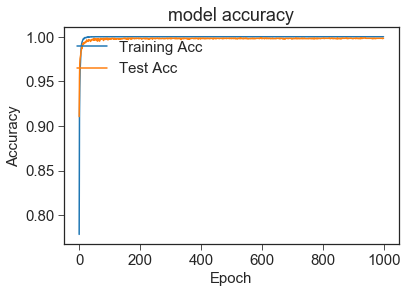

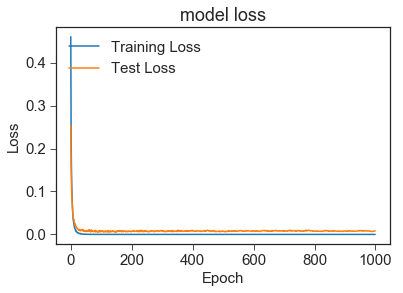

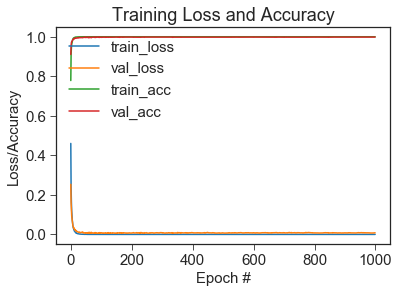

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")